# Demo with CIFAR10 test data and feature extraction
In this notebook, we are going to extract features of images. We do this only with the test data, since it is smaller and the notebook will execute faster, but you can easily do the same with the training data.

# Prerequisites

In [1]:
import numpy as np
from pathlib import Path
from PIL import Image

import torch
from torchvision.transforms import Compose
from torchvision.datasets import CIFAR10

from hyperpyper.transforms import (
    FileToPIL,
    PILtoHist,
    PILtoMagnSpectrum,
    RadialAvgSpectrum,
    SpectralCentroid,
    SpectralBandwidth,
    SpectralSlope,
    SpectralRollOff,
    FeatureUnion
    )

from hyperpyper.aggregator import DataAggregator

from hyperpyper.utils import VisionDatasetDumper
from hyperpyper.utils import FolderScanner as fs

import matplotlib.pyplot as plt

random_state = 23

In [2]:
ROOT_PATH = Path.home() / "Downloads" / "data"

DATA_PATH = ROOT_PATH / "CIFAR10"

DATA_PATH_TEST = Path(DATA_PATH, "test")

## Create CIFAR10 test dataset organized in subfolders indicating the corresponding class label
The VisionDatasetDumper handles the download and the creation of a folder structure where images are stored. They can then be used as the starting point for experiments.

In [3]:
test_dataset = VisionDatasetDumper(CIFAR10, root=DATA_PATH, dst=DATA_PATH_TEST, train=False).dump()

Files already downloaded and verified


### Retrieve a list of .png files

In [4]:
test_files = fs.get_files(DATA_PATH_TEST, extensions='.png', recursive=True)
len(test_files)

10000

## Define Transformation pipeline
Notice, that we have a FileToPIL Transformation that handles the loading of the image. This enables us to use the standard Aggregator, where we don't need to take care of a DataSet or DataLoader instantiation.
All we need to pass as arguments is a file list and the transformation pipeline, and optionally a batch size.

### Extract 2d Fourier magnitude spectrum

In [5]:
transform_pipeline = Compose([
    FileToPIL(mode='L'),
    PILtoMagnSpectrum(),
])

In [6]:
agg = DataAggregator(test_files, transforms=transform_pipeline, batch_size=1000)

test_features, test_feature_files = agg.transform()

In [7]:
test_features.shape

torch.Size([10000, 32, 32])

In [8]:
idx = 10
img_spectrum = test_features[idx]

file = test_feature_files[idx]

img = Image.open(file).convert('L')

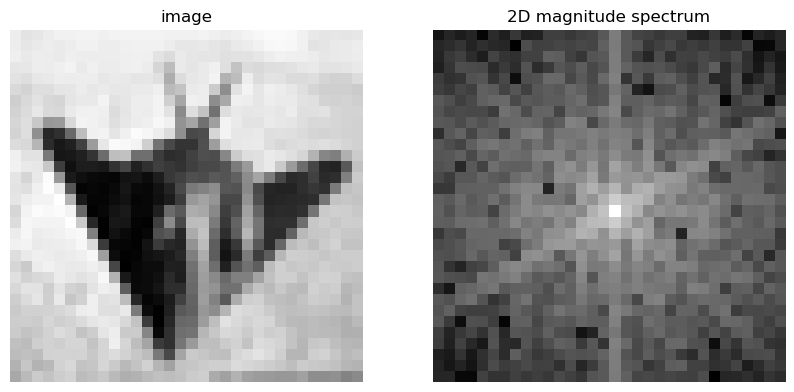

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img, cmap='gray', interpolation='none')
ax1.set_title('image')
ax1.axis("off")

ax2.imshow(img_spectrum, cmap='gray', interpolation='none')
ax2.set_title('2D magnitude spectrum')
ax2.axis("off");

## Pipeline to compute the radial average magnitude spectrum
This turns the sometimes hard to interpret 2D spectrum into a 1D representation.

In [10]:
transform_pipeline = Compose([
    FileToPIL(mode='L'),
    PILtoMagnSpectrum(),
    RadialAvgSpectrum(),
])

In [11]:
agg = DataAggregator(test_files, transforms=transform_pipeline, batch_size=1000)

test_features, test_feature_files = agg.transform()

### Due to the radial averaging, the length of the 1D representation does not match the side length of the 2D spectrum

In [12]:
test_features.shape

torch.Size([10000, 24])

In [13]:
idx = 10
img_spectrum = test_features[idx]

file = test_feature_files[idx]
img = Image.open(file).convert('L')

Text(0.5, 1.0, '1D radial average spectrum')

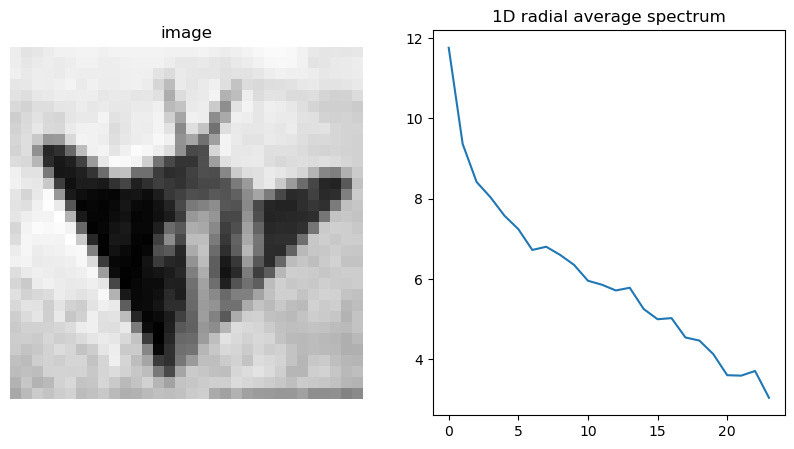

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img, cmap='gray', interpolation='none')
ax1.set_title('image')
ax1.axis("off")

ax2.plot(img_spectrum)
ax2.set_title('1D radial average spectrum')

## A pipeline to extract a feature from the 1D spectrum

In [15]:
transform_pipeline = Compose([
    FileToPIL(mode='L'),
    PILtoMagnSpectrum(),
    RadialAvgSpectrum(),
    SpectralCentroid()
])

In [16]:
agg = DataAggregator(test_files, transforms=transform_pipeline, batch_size=1000)

test_features, test_feature_files = agg.transform()

In [17]:
idx = 12
img_feature = test_features[idx]

file = test_feature_files[idx]
img = Image.open(file).convert('L')

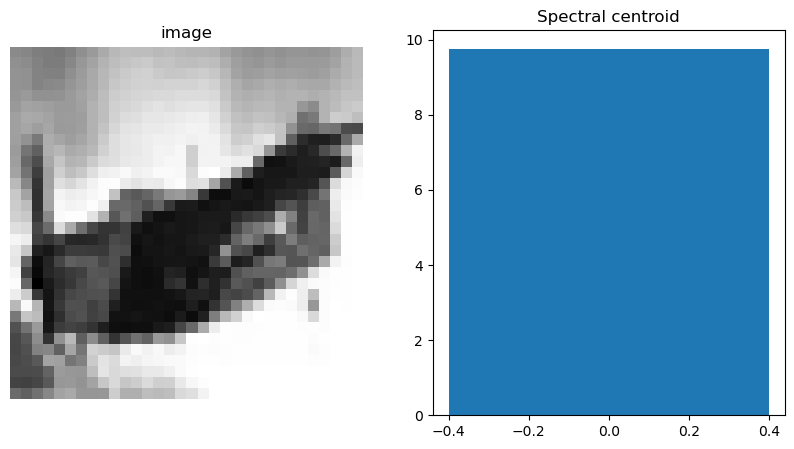

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img, cmap='gray', interpolation='none')
ax1.set_title('image')
ax1.axis("off")

ax2.bar(x=[0], height=[img_feature])
ax2.set_title('Spectral centroid');

## A pipeline to extract multiple features from a 1D spectrum

In [19]:
transform_pipeline = Compose([
    FileToPIL(mode='L'),
    PILtoMagnSpectrum(),
    RadialAvgSpectrum(),
    FeatureUnion(transforms=[
        SpectralCentroid(),
        SpectralBandwidth(),
        SpectralSlope(),
        SpectralRollOff(threshold=0.8),
        SpectralRollOff(threshold=0.5)
        ])
])

In [20]:
agg = DataAggregator(test_files[:100], transforms=transform_pipeline, batch_size=50)

test_features, test_feature_files = agg.transform()

### Feature keys in the resulting dict correspond to the transforms

In [21]:
test_features.keys()

dict_keys(['SpectralCentroid()', 'SpectralBandwidth()', 'SpectralSlope()', 'SpectralRollOff(threshold=0.8)', 'SpectralRollOff(threshold=0.5)'])

In [22]:
idx = 12

file = test_feature_files[idx]
img = Image.open(file).convert('L')

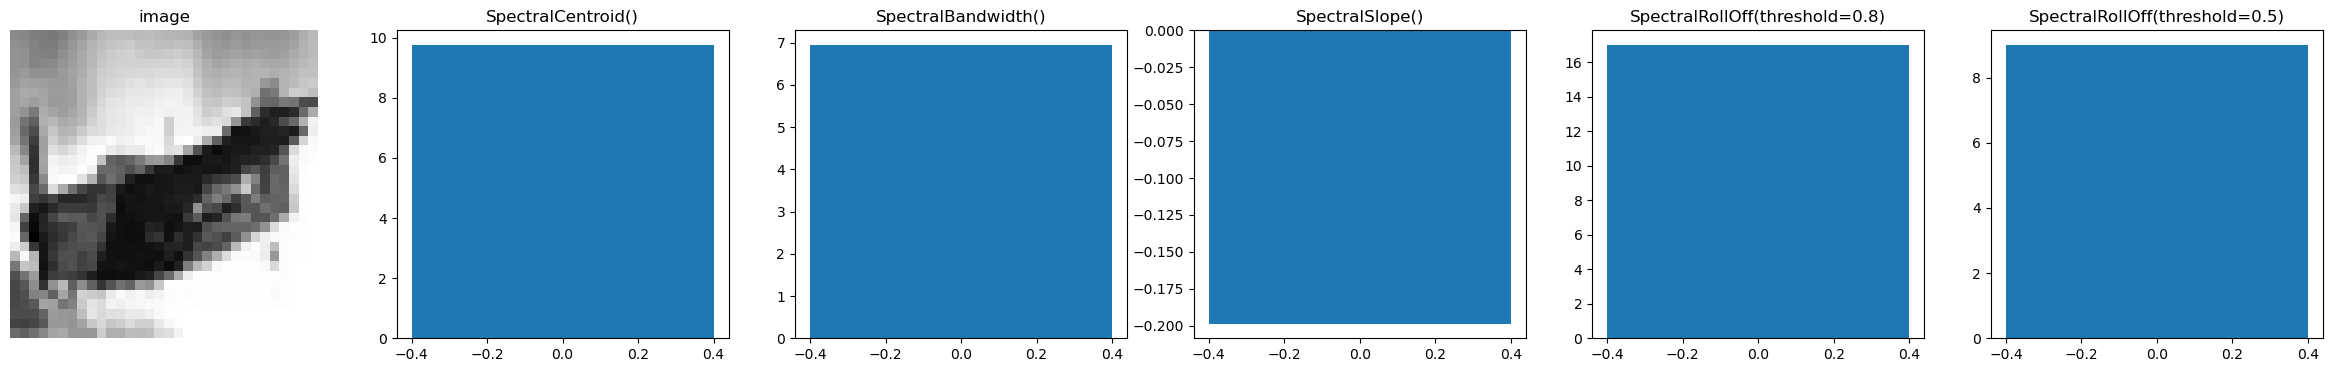

In [23]:
n_cols = len(test_features.keys())+1
fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 4))


axes[0].imshow(img, cmap='gray', interpolation='none')
axes[0].set_title('image')
axes[0].axis("off")

for i, key in enumerate(test_features.keys()):
    ax = axes[i+1]
    ax.bar(x=[0], height=[test_features[key][idx]])
    ax.set_title(key)